## データ分析の趣旨
iris dataにおける'versicolor', 'virginica'を分類することを目的とし、
<br>説明変数にsepal length (cm)と  'petal length (cm)'をとり、簡単なEDAで仮説をたててから検証する。

In [1]:
# import module
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

In [2]:
# import iris data
from sklearn.datasets import load_iris
iris_dataset = load_iris()
list(iris_dataset.target_names)

['setosa', 'versicolor', 'virginica']

In [3]:
# Check an iris dataset
# iris_dataset

In [4]:
# mold the array of iris to dataframe
X = pd.DataFrame(np.array(iris_dataset.data)) 

In [5]:
# head
X.head()

,0,1,2,3
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [6]:
# info
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
0    150 non-null float64
1    150 non-null float64
2    150 non-null float64
3    150 non-null float64
dtypes: float64(4)
memory usage: 4.8 KB


In [7]:
# describe
X.describe()

,0,1,2,3
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [8]:
# nan
X.isnull().sum() 

0    0
1    0
2    0
3    0
dtype: int64

欠損値がないので、そのまま分析を進める。

In [9]:
# rename the columns
columns_dic = {0: 'sepal_length', 1: 'sepal_width', 2: 'petal_length', 3: 'petal_width'}

X.rename(columns= columns_dic, inplace=True)
X.head()

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [10]:
# mold the array to dataframe
Y = pd.DataFrame(np.array(iris_dataset.target)) 

# rename a column
Y = Y.rename(columns = {0:'Species'})

# check the dataset
Y['Species'].value_counts()

2    50
1    50
0    50
Name: Species, dtype: int64

In [11]:
# combine features and categorie
df_iris = X.join(Y)

# check
df_iris.head()

,sepal_length,sepal_width,petal_length,petal_width,Species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [12]:
columns_process = ["sepal_length", "petal_length", "Species"]

# generate a dataframe for analyzing iris dataset
df_iris_del_index = df_iris[df_iris.Species != 0] # virgicolor and virginica

#　analysis about 'versicolor', 'virginica'
df_train_test = df_iris_del_index.loc[:, columns_process]
df_train_test['Species'] -= 1
df_train_test['Species'].unique()

array([0, 1])

<Figure size 1080x1080 with 0 Axes>

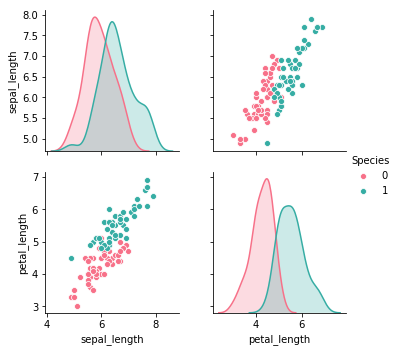

In [13]:
'''
Overview the histgram and plot
'''
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(15, 15))

sns.pairplot(df_train_test, vars=df_train_test.iloc[:,:2].columns, 
             hue="Species", palette="husl")

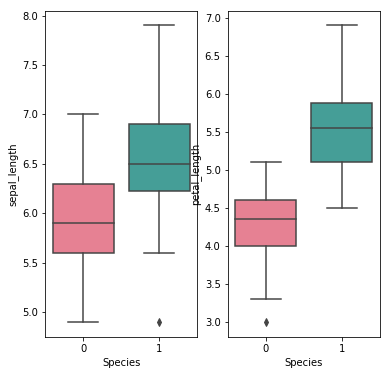

In [14]:
# plot box plot
fig = plt.figure(figsize=(6, 6))
ax1 = plt.subplot(1,2,1)
ax1 = sns.boxplot(x="Species", y="sepal_length", 
                  data=df_train_test, palette="husl") 
ax2 = plt.subplot(1,2,2)
ax2 = sns.boxplot(x="Species", y="petal_length", 
                  data=df_train_test, palette="husl")

In [15]:
# individual variable and non-dividual variable
X = df_train_test.iloc[:, :-1].values # by number/ values --> serries
y = df_train_test.loc[:, "Species"].values # by column's name

# for spliting train and test
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size = 0.3)

###### 【仮説】
予測モデルは、"petal_length"が5cm前後で、'versicolor', 'virginica'が分類される。
<br>"sepal_lenth"では、6.3cm前後で分類できるように見えるが、"petal_length"に比べ、信頼区間の精度は劣るのではないか。

###### 【検証方法】
決定木分析を用い、適切なパラメータを求め、二種分類の式を作成する。

## スクラッチによる実装

### 【問題1】ジニ不純度を求める関数
まずは空間を分割するための指標値、ジニ不純度を計算する関数を作成してください。ノード
tに対するジニ不純度I(t) は以下の数式で求まります。
$$
I(t) = 1-\sum_{i=1}^{K}P^2(C_i|t) = 1-\sum_{i=1}^{K}(\frac{N_{t,i}}{N_{t,all}})^{2}
$$
<br>
<br>t: ノードのインデックス
<br>i: クラスのインデックス
<br>K: クラスの数
<br>Ci: i番目のクラス
<br>P(Ci|t):t番目のノードにおける
<br>Ciの割合
<br>Nt,i: t番目のノードのi番目のクラスに属するサンプル数
<br>Nt,all: t番目のノードのサンプルの総数
<br>まずは簡単な例を作り、手計算と関数の結果を比較してください。
<br>
<br>例
<br>クラス1:サンプル数15, クラス2:サンプル数15 → ジニ不純度0.500
<br>クラス1:サンプル数15, クラス2:サンプル数15, クラス3:サンプル数15 → ジニ不純度0.667
<br>クラス1:サンプル数18, クラス2:サンプル数12 → ジニ不純度0.480
<br>クラス1:サンプル数30, クラス2:サンプル数0 → ジニ不純度0.000

In [38]:
# import numpy
import numpy as np

def gini_impurity(X, y, column, value):
    '''
    Compute gini impurity
    
    Parameters
    ----------
    X : features  
    y : traget
    column : the number of columns
    value : threshold

    Attributes
    ----------
    gini : gini impurity
    sample_num : number of parent nodes
    score : squere of (count of child node / number of parent node)
    '''
    gini = 0
    sample_num = len(y)
    
    div_y = [y[X[:, column] >= value], y[X[:, column] < value]] # search
#     print(div_y[0]) # the target group more than value; [0, 1 , 1, ........]
    
    for grp in div_y:
        score = 0
        classes = np.unique(grp) # search
        for cls in classes:
            ip = np.sum(grp == cls)/len(grp) # search
            score += ip * ip
        gini += (1- score) * (len(grp)/sample_num) #  actually gini * 　coefficient
    return gini

### 【問題2】情報利得を求める関数
<br>次に、情報利得を計算する関数を作成してください。先ほど作成したジニ不純度 
<br>I(t)を計算する関数を呼び出して使います。情報利得IGは以下の数式で求まります。
<br>
<br>
$$
IG(p) = I(p)-\frac{N_{left,all}}{N_{p,all}}I(left)-\frac{N_{right,all}}{N_{p,all}}I(right)
$$
<br>
<br>p: 親ノードを示すインデックス
<br>left: 左側のノードを示すインデックス
<br>right : 右側のノードを示すインデックス
<br>
<br>まずは簡単な例を作り、手計算と関数の結果を比較してください。
<br>
<br>例
<br>左ノードクラス1:サンプル数10, 左ノードクラス2:サンプル数30, 右ノードクラス1:サンプル数20, 右ノードクラス2:サンプル数5 → 情報利得0.128
<br>この他にもいくつか試してください。

In [43]:
def information_gain(X, y):
    '''
    Compute information gain
    
    Parameters
    ----------
    X : features  
    y : traget

    Attributes
    ----------
    gini : gini impurity
    
    '''
    gini = None
    gini_min = 1 # max==1
    columns = X.shape[1]
    best_column = None
    best_thrs = None # values

    for column in range(columns):
        values = X[:, column] # output val
        for val in values:
            gini = gini_impurity(X, y, column, val)
            if gini_min > gini:
                gini_min = gini #update
                best_thrs = val # update
                best_column = column #update
    return gini_min, best_thrs, best_column     

In [44]:
information_gain(X_train, y_train)

(0.15561015561015556, 4.9, 1)

### 【問題3】深さ1の決定木分類器クラスの作成
深さが1の決定機分類器のクラスを作成し、Sprint2で作成した分類のパイプラインに組み込んでください。
<br>クラスの基本構造はSprint3の線形回帰を参考にし、名前はScratchDecesionTreeClassifierとしてください。
<br>メソッドやパラメータなどはscikit-learnを参考にしてください。
<br>
<br>sklearn.tree.DecisionTreeClassifier — scikit-learn 0.20.2 documentation
<br>
<br>検証段階ではJupyter Notebook上で書いていき、最終的にはpyファイルにモジュールとしてまとめてください。
<br>深さ1とは空間の分割を1回だけ行うことを指します。
<br>
<br>・決定木のアルゴリズム
<br>ある特徴量の軸に対して、全てのパターンのしきい値を考え、それぞれの情報利得を計算していきます。各点の値をしきい値にする方法が一般的です。
（ただし、実際にはしきい値の数は点の数よりひとつ少なくて良いことになります）分割の全候補の中で最も情報利得が大きくなるものをそのノードの分割方法として採用します。
<br>ジニ不純度が0になるノード、または指定された深さのノードは葉と呼ばれます。葉にはそれぞれ推定時にどのクラスに分類するかを記録しておきます。
<br>ジニ不純度が0でない場合は、多数決により分類するクラスを決定します。
ヒント
<br>これまでのスクラッチ課題に比べてアルゴリズムが複雑です。コードを書く前に、フローチャートなどで整理するようにしましょう。

In [83]:
hoge = [1, 1, 3, 3, 3, 3, 3, 0, 0 ,0]
print(np.argmax(np.bincount(hoge)))
print(np.argmax(hoge))

3
2


In [153]:
class ScratchDecisionTreeDecide():
    def __init__(self, X, y, max_depth):
        self.X = X
        self.y = y
        self.left = None
        self.right = None
        self.max_depth = max_depth
        self.depth = None
        self.value = None
        self.column = None
        self.gini_min = None
        self.label = np.argmax(np.bincount(y)) # search
        
    def divide_class(self, depth):
        self.depth = depth
        self.gini_min, self.value, self.column = information_gain(self.X, self.y) # information gain
        print('Tree Depth: {}, Divided Feature: {},Threshold: {}, Label: {}'.format(self.depth, self.column, self.value, self.label)) # output
        
        # search
        if self.depth == self.max_depth or self.gini_min == 0:
            
            return       
        
        idx_left = self.X[:, self.column] >= self.value
        idx_right = self.X[:, self.column] < self.value
        
        self.left = ScratchDecisionTreeDecide(self.X[idx_left],  self.y[idx_left], self.max_depth)
        self.right = ScratchDecisionTreeDecide(self.X[idx_right], self.y[idx_right], self.max_depth)
        self.left.divide_class(self.depth +1)
        self.right.divide_class(self.depth +1)
        
    def predict(self, X):
        if self.gini_min == 0.0 or self.depth == self.max_depth:
            return self.label
        else:
            if X[self.column] > self.value:
                return self.left.predict(X)
            else:
                return self.right.predict(X)

In [154]:
class ScratchDecesionTreeClassifier():
    def __init__(self, max_depth):
        self.max_depth = max_depth
        self.tree = None
        
    def fit(self, X, y):
        init_depth = 0
        self.tree = ScratchDecisionTreeDecide(X, y, self.max_depth)
        self.tree.divide_class(init_depth)
        
    def predict(self, X):
        pred = []
        for num in X:
            pred.append(self.tree.predict(num))
        return np.array(pred)

In [155]:
clf = ScratchDecesionTreeClassifier(max_depth=3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Tree Depth: 0, Divided Feature: 1,Threshold: 4.9, Label: 0
Tree Depth: 1, Divided Feature: 1,Threshold: 5.1, Label: 1
Tree Depth: 2, Divided Feature: 0,Threshold: 6.1, Label: 1
Tree Depth: 3, Divided Feature: 0,Threshold: 7.3, Label: 1
Tree Depth: 3, Divided Feature: 0,Threshold: 6.0, Label: 1
Tree Depth: 2, Divided Feature: 0,Threshold: 6.7, Label: 1
Tree Depth: 3, Divided Feature: 0,Threshold: 6.7, Label: 0
Tree Depth: 3, Divided Feature: 0,Threshold: 6.3, Label: 1
Tree Depth: 1, Divided Feature: 0,Threshold: 5.0, Label: 0
Tree Depth: 2, Divided Feature: 1,Threshold: 4.8, Label: 0
Tree Depth: 3, Divided Feature: 0,Threshold: 6.8, Label: 0
Tree Depth: 3, Divided Feature: 0,Threshold: 5.0, Label: 0
Tree Depth: 2, Divided Feature: 1,Threshold: 4.5, Label: 0


### 【問題4】（アドバンス課題）深さ2の決定木分類器クラスの作成
問題3で作成したクラスを発展させ、深さが2の決定木分類器のクラスを作成してください。
深さ2とは空間の分割を2回行うことを指します。
ヒント
各ノードをインスタンスとして扱うと、任意の深さへの拡張が行いやすくなります。

### 【問題5】（アドバンス課題）任意の深さに対応できる決定木分類器クラスの作成
問題3,4で作成したクラスを発展させ、任意の深さに対応できる決定木分類器のクラスを作成してください。深さを特定の値で指定せず、全ての葉がジニ不純度0となるまで続けられるようにしてください。

## 検証

### 【問題6】指標値の算出
分類に関する指標値で精度を確認してください。

In [156]:
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score


"""

get scores: accuracy, pecision, recall, F measure

"""
def get_scores(y_test, y_pred):
    scores_array = np.hstack((accuracy_score(y_test, y_pred), 
                             precision_score(y_test, y_pred),
                             recall_score(y_test, y_pred),
                             f1_score(y_test, y_pred)))
    return scores_array
    
# scores = get_scores(y_test, y_pred)
# index_score = [ "accuracy","precision","recall","f1"]
# scores = pd.DataFrame(scores, index=index_score, columns={'iris_data':0})
# scores

In [157]:
get_scores(y_test, y_pred)

array([0.93333333, 1.        , 0.86666667, 0.92857143])

### 【問題7】決定領域の可視化
2値分類のデータセットに対して決定領域を可視化してください。

In [158]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

def decision_region(X_train, y_train, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    """
    Draw the decision area of the model learned by binary classification with two dimensional 
    feature quantity.
     The color of the background is drawn from the estimated value by the learned model.
     The point of the scatter diagram is learning data.

     Parameters
     ------------------
     X_train: ndarray, shape (n_samples, 2)
         Characteristic quantity of learning data
     y_train: ndarray, shape (n_samples,)
         Correct value of learning data
     model: object
         **** Insert Instantus of the learned model
     step: float, (default: 0.1)
         Set interval to calculate estimated value
     title: str
         Give the text of the title of the graph
     xlabel, ylabel: str
         Give sentences of axis labels
     target_names =: list of str
         Give a list of legends
    """
    # define Initial setting 
    fig, ax = plt.subplots(figsize=(6, 6))
    fig.patch.set_facecolor('skyblue')
    fig.patch.set_alpha(1)
    ax.patch.set_facecolor('white')
    ax.patch.set_alpha(1)
    # ax.set_yscale('log') 
    plt.grid()
    
    # setting
    scatter_color = ['red', 'green']
    contourf_color = ['pink', 'skyblue']
    n_class = 2

    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X_train[:,0])-0.5, np.max(X_train[:,0])+0.5, step), np.arange(np.min(X_train[:,1])-0.5, np.max(X_train[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    pred = model.predict(mesh).reshape(mesh_f0.shape)

    # plot setting title
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.contour(mesh_f0, mesh_f1, pred, n_class-1, colors='g', linewidths=5, alpha=0.5)
    
    for i, target in enumerate(set(y_train)):
        plt.scatter(X_train[y_train==target][:, 0], X_train[y_train==target][:, 1], s=150, color=scatter_color[i], label=target_names[i], 
                    marker='x', alpha=0.7)
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

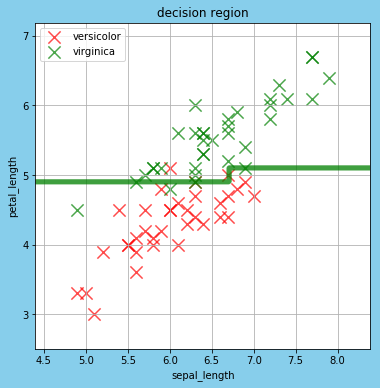

In [160]:
decision_region(X_train, y_train, clf, xlabel='sepal_length', ylabel='petal_length')

#### 考察
仮説では"petal_length"が5cm前後で、'versicolor', 'virginica'が分類され、"sepal_lenth"は、6.3cm前後で分類できるように見えるが、"petal_length"に比べ、信頼区間の精度は劣るのではないかと考えた。
<br>
<br> テストデータの予測の結果を見ると、"petal_length"が5.0(cm)前後で線が引かれ、"sepal_lenth"が6.7(cm)前後で線が引かれていることがわかる。
<br>
<br>以上から考えると、仮説は非常に予測結果に近かったと言える。

## ディスカッション

### 【問題8】決定木の利用場面
<br>最終発表時に以下の内容についてディスカッションを行います。
<br>自分なりの意見を用意しておいてください。
<br>決定木が他の手法に比べて有効だと考えられるのはどういった場面か
<br>
<br>注意点
<br>答えがある問いではありません。いろいろな視点から見て理解を深めていきましょう。

・クライエントへのプレゼンテーションの際、一番初めに説明するシンプルなモデル
<br>・決定木（回帰木）→重回帰分析→　SVMなどのモデルの順番で説明すると統計の知識がない人はわかりやすい。
<br>・推論過程が人間の仮説に近くなるため、他人に説明がしやすい。